In [1]:
import os
import json
from web3 import Web3, HTTPProvider

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [3]:
pool_contract = "0x9838eCcC42659FA8AA7daF2aD134b53984c9427b"
token_contract = "0x3b6831c0077a1e44ED0a21841C3bC4dC11bCE833"

In [4]:
with open("./eurt_3crv.json", 'r') as f:
    abi = json.load(f)

contract = web3.eth.contract(address=pool_contract, abi=abi)

In [21]:
block_ranges = [(13526617, 13619082)]

In [22]:
admin_fee_claims = []
for (block_start, block_end) in block_ranges:

    # swaps:
    event_filter = contract.events.ClaimAdminFee.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    claim_admin_fee_events = event_filter.get_all_entries()
    for event in claim_admin_fee_events:
        tokens_claimed = event['args']['tokens'] * 1e-18
        block = event['blockNumber']

        admin_fee_claims.append(
            {
                'block': block,
                'tokens_claimed': tokens_claimed,
            }
        )

In [23]:
df_admin_fee_claims = pd.DataFrame(admin_fee_claims)
df_admin_fee_claims['oracle_price'] = 0
for idx, row in df_admin_fee_claims.iterrows():

    virtual_price = contract.functions.get_virtual_price().call(block_identifier=int(row.block)) * 1e-18
    oracle_price = contract.functions.price_oracle().call(block_identifier=int(row.block)) * 1e-18

    computed_lp_oracle_price = 2 * virtual_price * (oracle_price)**(1./2)

    df_admin_fee_claims.loc[idx, 'oracle_price'] = computed_lp_oracle_price

df_admin_fee_claims['total_claimed'] = (
        df_admin_fee_claims.tokens_claimed * df_admin_fee_claims.oracle_price
)

In [24]:
df_admin_fee_claims

,block,tokens_claimed,oracle_price,total_claimed
0,13609938,19468.346923,1.866470,36337.080149
1,13615241,3452.419587,1.874499,6471.557637
2,13619082,408.489805,1.885868,770.357832


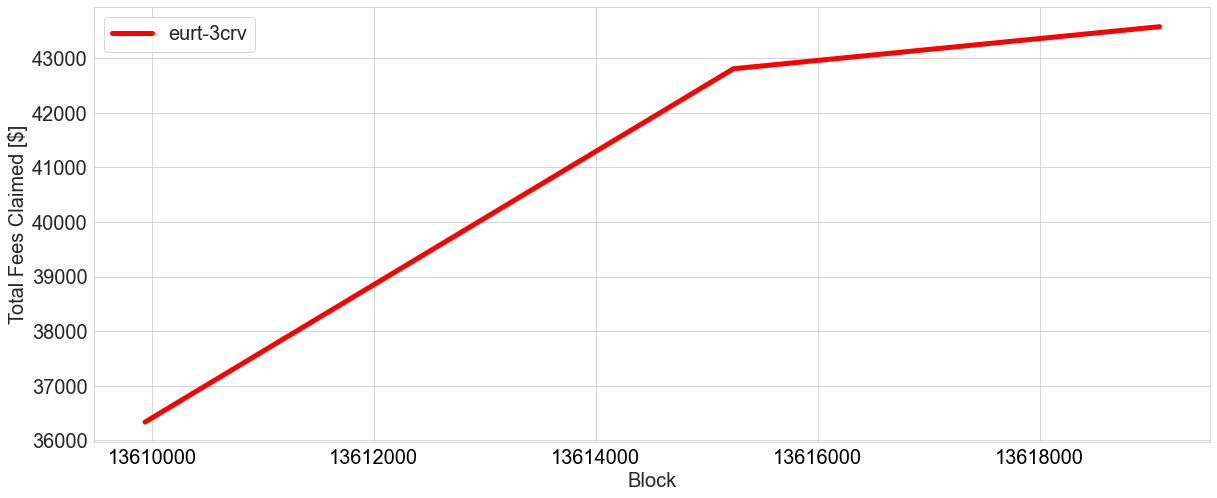

In [25]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ax.plot(
    df_admin_fee_claims.block,
    df_admin_fee_claims.total_claimed.cumsum(),
    color='red',
    lw=5,
    label='eurt-3crv'
)


ax.set_xlabel("Block", fontsize=20)
ax.set_ylabel("Total Fees Claimed [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)